# 🔎 Recognizability and 🎆 Diversity

The ideas of recognizability and diversity of a data set introducted by Boutin et al. (2022) are used to evaluate the ability of a generative model to create useful data. The recognizability metric is easiest to understand as simply how easy (or difficult) it is for the data to be classified. Therefore, in the case of the drone data it is just a measure of how easily the drone objects can be identified within the images. Diversity is best thought of as the variance of the feature space of the data set.

`Boutin, V., Singhal, L., Thomas, X., & Serre, T. (2022). Diversity vs. Recognizability: Human-like generalization in one-shot generative models. Advances in Neural Information Processing Systems, 35, 20933-20946.`

In [12]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os

from src import utils

## 1. File Prep

In [2]:
# Create the staging directory if it doesn't exist
os.makedirs(os.path.join("data", "staging"), exist_ok=True)
# Create the test folder in the staging directory if it doesn't exist
os.makedirs(os.path.join("data", "staging", "test"), exist_ok=True)
# Create train and val folders (they won't be used but need to exist for the YOLO model functions)
os.makedirs(os.path.join("data", "staging", "train"), exist_ok=True)
os.makedirs(os.path.join("data", "staging", "val"), exist_ok=True)

In [3]:
# Create the YOLO yaml file
yaml_path = os.path.join("data", "staging", "evaluation.yaml")

# YAML content
yaml_content = """
path: data/staging  # dataset root dir (leave empty for HUB)
train: train  # train images (relative to 'path')
val:   val    # val images (relative to 'path')
test:  test   # test images (relative to 'path')

names:
  0: drone
"""

# Write the YAML content to the file
with open(yaml_path, 'w') as yaml_file:
    yaml_file.write(yaml_content)

**Experimental Design**

| **Run** | **Authentic Data** | **3D Model Data** | **Clipart Data** | **Gen AI Data** |
| --- | --- | --- | --- | --- |
| 00  | 100 | 0   | 0   | 0   |
| 01  | 26  | 27  | 23  | 24  |
| 02  | 0   | 57  | 22  | 21  |
| 03  | 0   | 27  | 73  | 0   |
| 04  | 27  | 0   | 0   | 73  |
| 05  | 27  | 33  | 40  | 0   |
| 06  | 38  | 0   | 33  | 29  |
| 07  | 38  | 33  | 29  | 0   |
| 08  | 0   | 0   | 76  | 24  |
| 09  | 0   | 24  | 52  | 24  |
| 10  | 0   | 100 | 0   | 0   |
| 11  | 27  | 73  | 0   | 0   |
| 12  | 0   | 0   | 30  | 70  |
| 13  | 29  | 0   | 36  | 35  |
| 14  | 70  | 30  | 0   | 0   |
| 15  | 72  | 0   | 0   | 28  |
| 16  | 0   | 0   | 100 | 0   |
| 17  | 26  | 35  | 0   | 39  |
| 18  | 0   | 27  | 0   | 73  |
| 19  | 0   | 70  | 30  | 0   |
| 20  | 40  | 30  | 0   | 30  |
| 21  | 27  | 0   | 73  | 0   |
| 22  | 70  | 0   | 30  | 0   |
| 23  | 0   | 0   | 0   | 100 |
| 24  | 0   | 26  | 27  | 47  |
| 25  | 0   | 72  | 0   | 28  |
| 26* | 0   | 0   | 50  | 50  |
| 27* | 0   | 50  | 0   | 50  |
| 28* | 0   | 50  | 50  | 0   |
| 29* | 0   | 33  | 33  | 33  |

`* denotes extra runs that were added`

In [4]:
# Model suffixes
# It would be better to do this by searching the directory, but this is quicker for now.
model_00 = "baseline"

model_01 = "26-27-23-24"
model_02 = "0-56-22-21"
model_03 = "0-27-73-0"
model_04 = "27-0-0-73"
model_05 = "27-33-40-0"
model_06 = "38-0-33-28"
model_07 = "38-33-28-0"
model_08 = "0-0-76-24"
model_09 = "0-24-52-24"
model_10 = "0-100-0-0"
model_11 = "27-73-0-0"
model_12 = "0-0-30-70"
model_13 = "28-0-36-35"
model_14 = "70-30-0-0"
model_15 = "72-0-0-28"
model_16 = "0-0-100-0"
model_17 = "26-35-0-39"
model_18 = "0-27-0-73"
model_19 = "0-70-30-0"
model_20 = "40-30-0-30"
model_21 = "27-0-73-0"
model_22 = "70-0-30-0"
model_23 = "0-0-0-100"
model_24 = "0-26-27-47"
model_25 = "0-72-0-28"
model_26 = "0-0-50-50"
model_27 = "0-50-0-50"
model_28 = "0-50-50-0"
model_29 = "0-33-33-33"

# Combine all model suffixes into a list
model_suffixes = [model_00,
                  model_01,
                  model_02,
                  model_03,
                  model_04,
                  model_05,
                  model_06,
                  model_07,
                  model_08,
                  model_09,
                  model_10,
                  model_11,
                  model_12,
                  model_13,
                  model_14,
                  model_15,
                  model_16,
                  model_17,
                  model_18,
                  model_19,
                  model_20,
                  model_21,
                  model_22,
                  model_23,
                  model_24,
                  model_25,
                  model_26,
                  model_27,
                  model_28,
                  model_29]

In [5]:
# Create directories if they don't exist
for suffix in model_suffixes:
    dir_path = os.path.join("model", f"model_{suffix}")
    os.makedirs(dir_path, exist_ok=True)

In [6]:
# Create a dictionary of important file paths for each model
model_paths = {
    suffix: {
        "weights": os.path.join("model", f"model_{suffix}", "weights", "best.pt"),
        "train_df": os.path.join("model", f"model_{suffix}", f"train_data_{suffix}.csv"),
        "val_df": os.path.join("model", f"model_{suffix}", f"val_data_{suffix}.csv"),
        "results_df": os.path.join("model", f"model_{suffix}", "results", f"results_{suffix}.csv"),
        }
    for suffix in model_suffixes
}

In [7]:
# Weights file for the baseline model for comparison purposes
baseline_model = model_paths[model_00]["weights"]

## 2. Data Collection

In [10]:
# Create a combined results dataframe to store all results
combined_results_df = pd.DataFrame(columns=["data_blend", "map50", "map50-95", "total_variance"])

# Loop through the different models
for suffix in model_suffixes:
    
    print("=" * 50)
    print(f"Processing model_{suffix}")
    print("-" * 50)
    
    # Cleanup staging directory
    print("Cleaning up staging directory...")
    utils.files.cleanup_staging()
    print("Cleaning complete.")
    print("-" * 50)
    
    # Create a results dataframe to store the results
    metrics_df = pd.DataFrame(columns=["data_blend", "map50", "map50-95", "total_variance"])
    
    # Move data to the staging directory
    print("Copying data to staging directory...")
    print(f"\tReading training data from: {model_paths[suffix]['train_df']}")
    print(f"\tReading validation data from: {model_paths[suffix]['val_df']}")
    train_df = pd.read_csv(model_paths[suffix]["train_df"])
    val_df = pd.read_csv(model_paths[suffix]["val_df"])
    utils.files.copy_to_staging(train_df, stage="test")
    utils.files.copy_to_staging(val_df, stage="test")
    print("Data copy complete.")
    print("-" * 50)
    
    # Do stuff
    # Load the model
    print(f"Loading baseline model from: {baseline_model}...")
    model = YOLO(baseline_model)
    print("Model loaded.")
    print("-" * 50)
    
    # Evaluate the model on the data mix
    # Assess the recognizability metric (mAP50 and mAP50-95)
    print("Evaluating model recognizability...")
    print("Running data blend through baseline model for evaluation...")
    recog_results = model.val(data=yaml_path, split="test")
    model_map50 = recog_results.box.map50
    model_map50_95 = recog_results.box.map
    print("Evaluation complete.")
    print(f"mAP50: {model_map50:.4f}")
    print(f"mAP50-95: {model_map50_95:.4f}")
    print("-" * 50)
    
    # Evaluate the diversity metric
    print("Evaluating model diversity...")
    layer_indicies = [10, 14, 17] # Indices of layers to extract feature embeddings from
    blend_images = utils.files.get_image_files(os.path.join("data", "staging", "test"))
    print(f"Extracting feature embeddings from {len(blend_images)} test images...")
    div_results = []
    for img in blend_images:
        div_result = model.predict(img, embed=layer_indicies, verbose=False)
        div_results.append(div_result[0])
    print("Stacking feature embeddings into a single tensor...")
    div_tensor = torch.stack(div_results)
    print(f"Feature embeddings tensor shape: {div_tensor.shape}")
    print("Calculating total variance across feature embeddings...")
    cov_matrix = torch.cov(div_tensor.view(div_tensor.size(0), -1).T)
    diversity_metric = torch.trace(cov_matrix).item()
    print(f"Total Variance (Diversity Metric): {diversity_metric:.4f}")
    print("Diversity evaluation complete.")
    print("-" * 50)
    
    # Append results to the dataframe
    print("Saving results...")
    print(f"Ensuring file path exists: {model_paths[suffix]['results_df']}")
    os.makedirs(os.path.dirname(model_paths[suffix]['results_df']), exist_ok=True)
    metrics = pd.Series({
        "data_blend": suffix,
        "map50": model_map50,
        "map50-95": model_map50_95,
        "total_variance": diversity_metric
        })
    metrics_df = pd.concat([metrics_df, metrics.to_frame().T], ignore_index=True)
    combined_results_df = pd.concat([combined_results_df, metrics.to_frame().T], ignore_index=True)
    # Save the results dataframe
    metrics_df.to_csv(model_paths[suffix]["results_df"], index=False)
    print("Results saved.")
    
print("=" * 50)
print("All models processed.")

# Save the combined results dataframe
combined_results_path = os.path.join("reports", "diversity_recognizability_results.csv")
combined_results_df.to_csv(combined_results_path, index=False)
print("Combined results saved.")


Processing model_baseline
--------------------------------------------------
Cleaning up staging directory...
Cleaning complete.
--------------------------------------------------
Copying data to staging directory...
	Reading training data from: model\model_baseline\train_data_baseline.csv
	Reading validation data from: model\model_baseline\val_data_baseline.csv
Data copy complete.
--------------------------------------------------
Loading baseline model from: model\model_baseline\weights\best.pt...
Model loaded.
--------------------------------------------------
Evaluating model recognizability...
Running data blend through baseline model for evaluation...
Ultralytics 8.3.221  Python-3.13.5 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11x summary (fused): 190 layers, 56,828,179 parameters, 0 gradients, 194.4 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 147.2127.1 MB/s, size: 1192.6 KB)
val: Scanning E:\Python\synthetic-data-for-object-detection\data\stagi

## 3. Visualizations

In [11]:
# Read the saved dataframe
full_data_df = pd.read_csv("reports\\diversity_recognizability_results.csv")

In [13]:
# Split into series for clarity
recog_map50 = full_data_df["map50"]
recog_map50_95 = full_data_df["map50-95"]
diversity_metric = full_data_df["total_variance"]

In [21]:
# Normalize diversity metric for better visualization
diversity_metric_normalized = (diversity_metric - diversity_metric.min()) / (diversity_metric.max() - diversity_metric.min())

In [18]:
%matplotlib inline

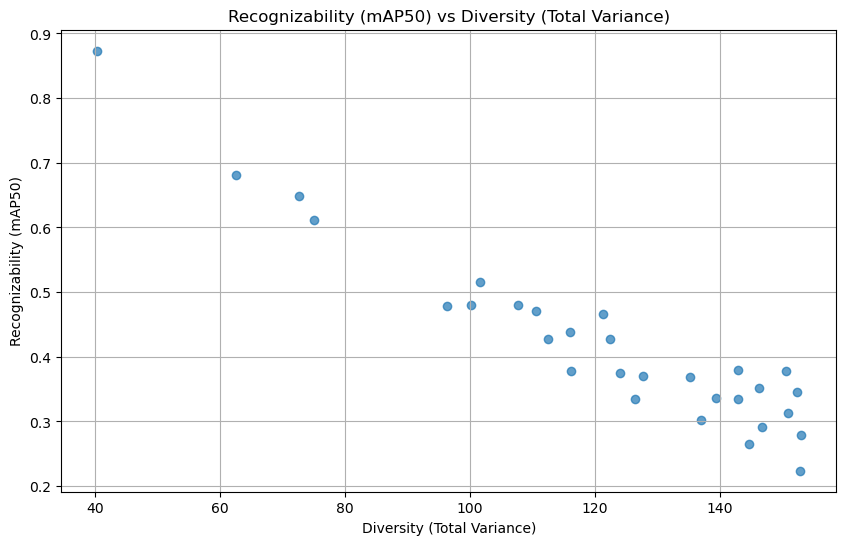

In [19]:
# Plot map50 vs total variance
plt.figure(figsize=(10, 6))
plt.scatter(diversity_metric, recog_map50, alpha=0.7)
plt.title("Recognizability (mAP50) vs Diversity (Total Variance)")
plt.xlabel("Diversity (Total Variance)")
plt.ylabel("Recognizability (mAP50)")
plt.grid()
plt.show()

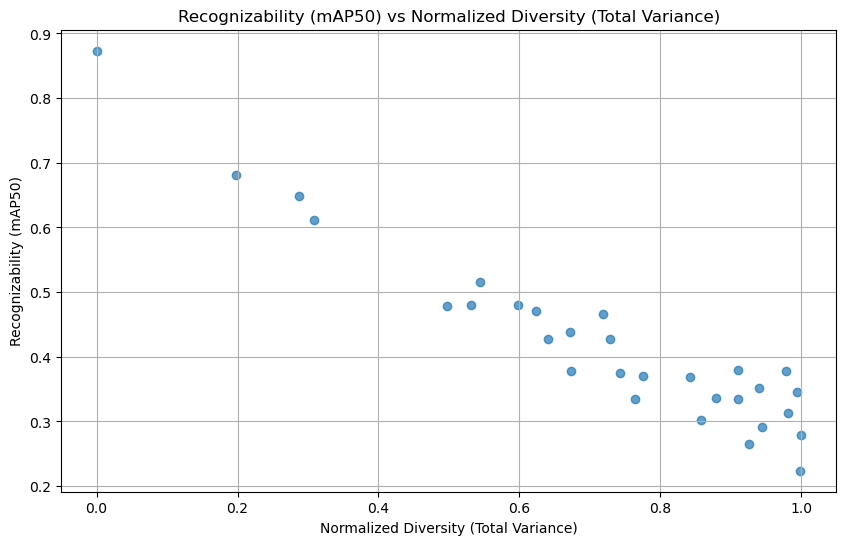

In [22]:
# Plot map50 vs total variance (normalized)
plt.figure(figsize=(10, 6))
plt.scatter(diversity_metric_normalized, recog_map50, alpha=0.7)
plt.title("Recognizability (mAP50) vs Normalized Diversity (Total Variance)")
plt.xlabel("Normalized Diversity (Total Variance)")
plt.ylabel("Recognizability (mAP50)")
plt.grid()
plt.show()

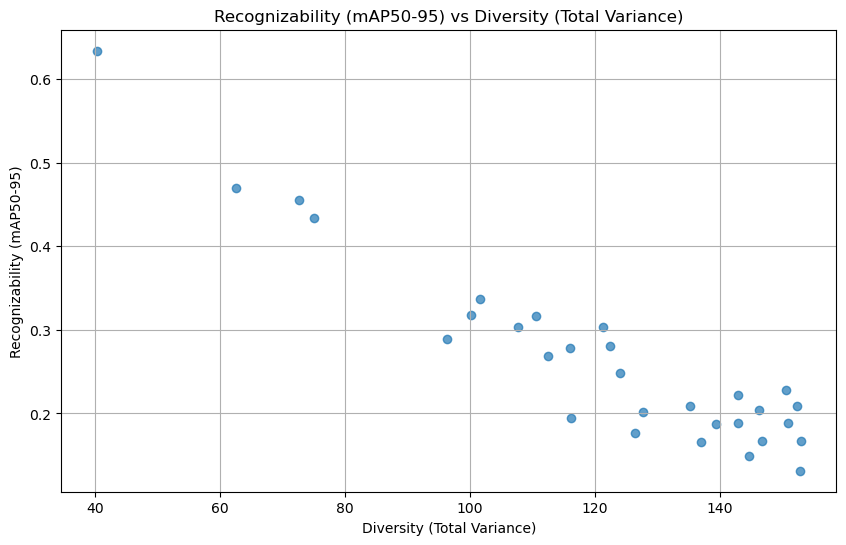

In [20]:
# Plot map50-95 vs total variance
plt.figure(figsize=(10, 6))
plt.scatter(diversity_metric, recog_map50_95, alpha=0.7)
plt.title("Recognizability (mAP50-95) vs Diversity (Total Variance)")
plt.xlabel("Diversity (Total Variance)")
plt.ylabel("Recognizability (mAP50-95)")
plt.grid()
plt.show()

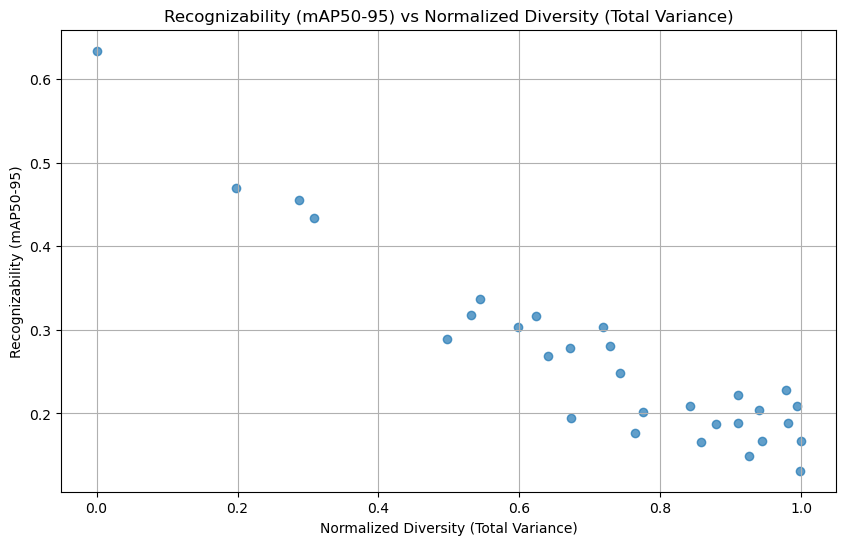

In [23]:
# Plot map50-95 vs total variance (normalized)
plt.figure(figsize=(10, 6))
plt.scatter(diversity_metric_normalized, recog_map50_95, alpha=0.7)
plt.title("Recognizability (mAP50-95) vs Normalized Diversity (Total Variance)")
plt.xlabel("Normalized Diversity (Total Variance)")
plt.ylabel("Recognizability (mAP50-95)")
plt.grid()
plt.show()